#### Import libraries

In [2]:
import pandas as pd
import geopandas as gpd
from census import Census
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np
pd.options.display.max_columns =200
import mapclassify

# Social Vulnerability Index for Mapping Community Health Worker Need

This notebook shows preliminary mapping of the CDC's [Social Vulnerability Index](https://svi.cdc.gov/). 

In particular comparisons between county and census tract level svi data. 

Full documentation for 2018 data is available [here](https://svi.cdc.gov/data-and-tools-download.html).


### I. Importing SVI data and computing state percentile ranking

The CDC uses both a USA-wide percentile ranking and a state by state percentile ranking. For our project given that funding is likely going to be managed at a state level using a state percentile ranking makes the most sense and will be most sensitive to regional socioeconomic differences. What do others think?

In [3]:
## import SVI data
svi = gpd.read_file("data/svi/SVI2018_US_tract.geojson")
svi_tribal = gpd.read_file("data/svi/SVI2018_tribal_tract.geojson")
svi_puerto_rico = gpd.read_file("data/svi/SVI2018_PuertoRico_tract.geojson")

In [3]:
# ## add in puerto rico to USA-wide dataset
# svi_pr = svi.append(svi_puerto_rico)

# ## select just locations with non-N/A values for 'SPL_THEMES' field
# svi_pr_forRPL = svi_pr[svi_pr['SPL_THEMES'] != -999].copy()
# svi_pr_forRPL_na = svi_pr[svi_pr['SPL_THEMES'] == -999].copy()

# ## calculate state percentile rank for combined svi variable
# svi_pr_forRPL['RPL_ThemesStates'] = svi_pr_forRPL.groupby('STATE')['SPL_THEMES'].rank(pct=True)

# ## append no data values back to dataset for complete set
# svi_states = svi_pr_forRPL.append(svi_pr_forRPL_na)

In [4]:
## import svi data by county
svi_counties = gpd.read_file("data_processing/svi/SVI2018_US_COUNTY/SVI2018_US_county.shp")

In [5]:
## replacing -999 values with nan for calculations
svi = svi.replace(-999,np.nan)
svi_counties = svi_counties.replace(-999,np.nan)

In [6]:
## calculating state by state percentile rank for tract svi
svi['RPL_ThemesStates'] = svi.groupby('STATE')['SPL_THEMES'].rank(pct=True)
svi['RPL_Theme1States'] = svi.groupby('STATE')['SPL_THEME1'].rank(pct=True)
svi['RPL_Theme2States'] = svi.groupby('STATE')['SPL_THEME2'].rank(pct=True)
svi['RPL_Theme3States'] = svi.groupby('STATE')['SPL_THEME3'].rank(pct=True)
svi['RPL_Theme4States'] = svi.groupby('STATE')['SPL_THEME4'].rank(pct=True)

In [223]:
## export tracts svi to csv
# svi.to_csv("data/svi/svi_2018_tracts_state_ranked.csv")

In [9]:
## exporting tracts svi to geojson
svi.to_file("data/svi/svi_2018_tracts_state_ranked.geojson",driver='GeoJSON')

In [6]:
## calculating state by state percentile rank for county svi

svi_counties['RPL_ThemesStatesCt'] = svi_counties.groupby('STATE')['SPL_THEMES'].rank(pct=True)
svi_counties['RPL_Theme1StatesCt'] = svi_counties.groupby('STATE')['SPL_THEME1'].rank(pct=True)
svi_counties['RPL_Theme2StatesCt'] = svi_counties.groupby('STATE')['SPL_THEME2'].rank(pct=True)
svi_counties['RPL_Theme3StatesCt'] = svi_counties.groupby('STATE')['SPL_THEME3'].rank(pct=True)
svi_counties['RPL_Theme4StatesCt'] = svi_counties.groupby('STATE')['SPL_THEME4'].rank(pct=True)

### II. comparing state and tract svi

In [204]:
sel_columns = ['FIPS','RPL_ThemesStatesCt','RPL_Theme1StatesCt',
               'RPL_Theme2StatesCt','RPL_Theme3StatesCt','RPL_Theme4StatesCt','geometry']

svi_comp = svi.merge(svi_counties[sel_columns],how='left',left_on='STCNTY', right_on='FIPS')

svi_comp['RPL_diff']=svi_comp['RPL_ThemesStates']-svi_comp['RPL_ThemesStatesCt']

In [205]:
svi_comp = gpd.GeoDataFrame(svi_comp,geometry='geometry_x')
svi_comp.crs = {'init': 'epsg:4269'}

/Users/darebrawley/anaconda3/envs/chw/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [169]:
svi_grouped = svi_comp.groupby(["STCNTY"]).agg({"STATE":'first',"STCNTY":'first',
                                        "ST":'first',"FIPS_x":'first',"RPL_ThemesStates":[min,max],
                                      "RPL_Theme1States":[min,max],
                                      "RPL_Theme2States":[min,max],
                                     "RPL_Theme3States":[min,max],
                                     "RPL_Theme4States":[min,max],
                                     "RPL_ThemesStatesCt":'first',
                                     "RPL_Theme1StatesCt":'first',
                                     "RPL_Theme2StatesCt":'first',
                                     "RPL_Theme3StatesCt":'first',
                                     "RPL_Theme4StatesCt":'first',
                                     "geometry_y":'first'},)

In [170]:
## min tract vs county
svi_grouped['RPL_Themes_mindiff'] = svi_grouped[('RPL_ThemesStates','min')]-svi_grouped[('RPL_ThemesStatesCt', 'first')]
svi_grouped['RPL_Themes_minperdiff'] = svi_grouped[('RPL_ThemesStates','min')]/svi_grouped[('RPL_ThemesStatesCt', 'first')]

## max tract vs county
svi_grouped['RPL_Themes_maxdiff'] = svi_grouped[('RPL_ThemesStates','max')]-svi_grouped[('RPL_ThemesStatesCt', 'first')]
svi_grouped['RPL_Themes_maxperdiff'] = svi_grouped[('RPL_ThemesStates','max')]/svi_grouped[('RPL_ThemesStatesCt', 'first')]

## unstacking columns
svi_grouped.columns = ['_'.join(col).strip('_') for col in svi_grouped.columns]


In [171]:
# convert back to geodataframe
svi_grouped = gpd.GeoDataFrame(svi_grouped,geometry='geometry_y_first')

In [173]:
svi_grouped.crs = {'init': 'epsg:4269'}

/Users/darebrawley/anaconda3/envs/chw/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


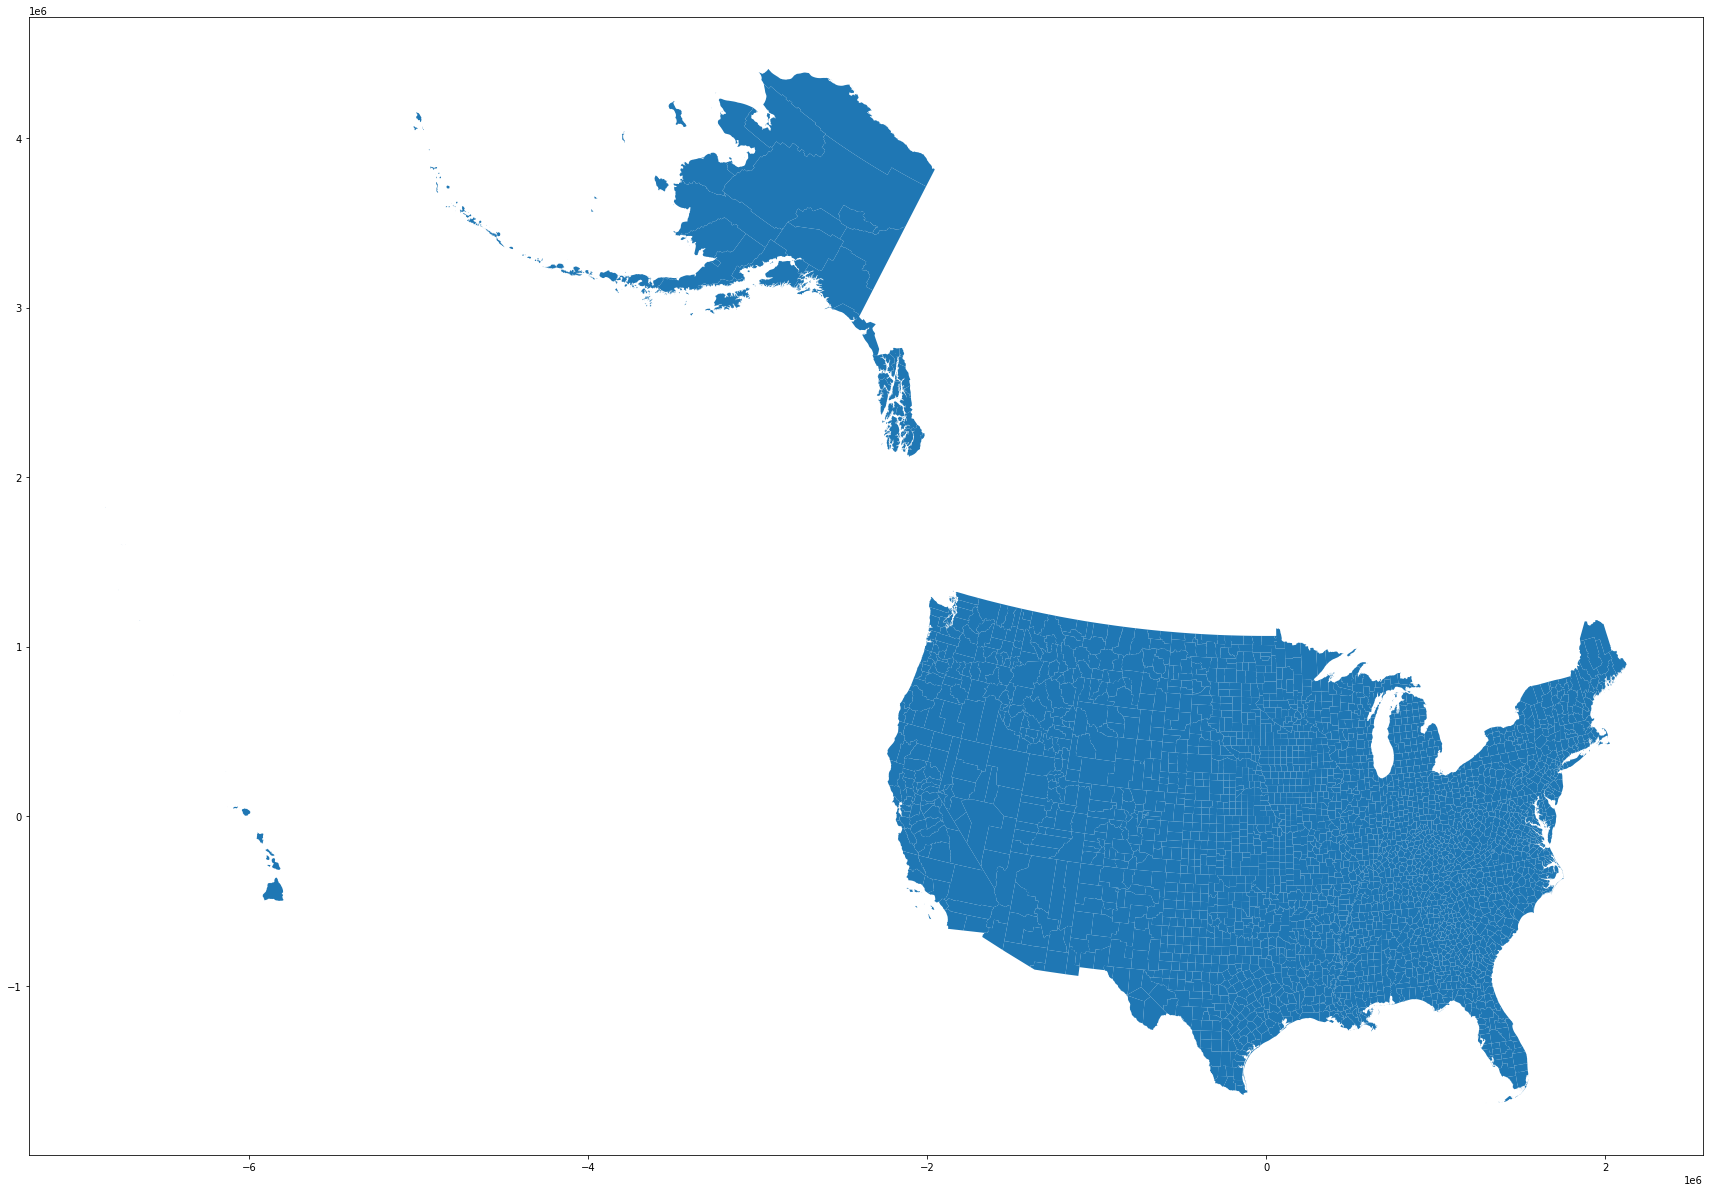

In [182]:
svi_grouped.plot(figsize=(30,30))

### III. Mapping CDC Social Vulnerability Index  

The following are preliminary maps of the state SVI rankings. 

In [216]:
## importing county shapefiles to be able to make regional maps
pr_view = gpd.read_file("data/puerto_rico.geojson")
ak_view = gpd.read_file("data/alaska.geojson")
hi_view = gpd.read_file("data/hawaii.geojson")
lower_view = gpd.read_file("data/lower_48.geojson")

## reprojecting lower 48 to albers usa equal area conic
lower_view = lower_view.to_crs("EPSG:3857")

## reprojecting pr to state plane 6566 
pr_view = pr_view.to_crs('EPSG:6566')

## defining bounding boxes
lower48_xlim = ([lower_view.total_bounds[0],lower_view.total_bounds[2]])
lower48_ylim = ([lower_view.total_bounds[1],lower_view.total_bounds[3]])

#defining bounding box pr
pr_xlim = ([pr_view.total_bounds[0],pr_view.total_bounds[2]])
pr_ylim = ([pr_view.total_bounds[1],pr_view.total_bounds[3]])

## for plotting -- reprojecting to albers usa
svi_comp_merc = svi_comp.to_crs("EPSG:3857")

## for plotting -- reprojecting to albers usa
svi_grouped = svi_grouped.to_crs("ESRI:102008")

## for plotting -- reprojecting to albers usa
svi_comp_albers = svi_comp.to_crs("ESRI:102008")


#### USA as a whole

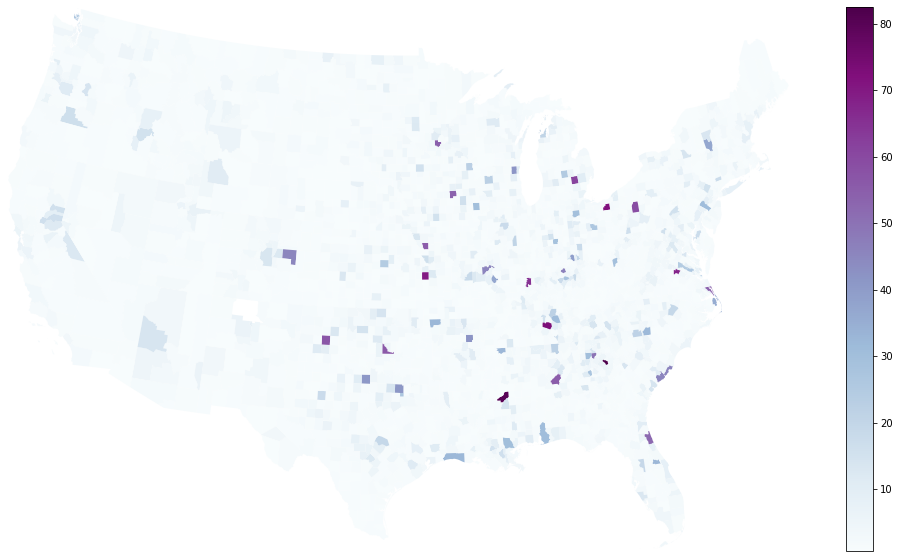

In [177]:

fig, ax = plt.subplots(figsize=(20,10))
svi_grouped.plot(ax=ax, column='RPL_Themes_maxperdiff', legend=True,cmap="BuPu")
ax.set_xlim(lower48_xlim)
ax.set_ylim(lower48_ylim)
# ax.set_title("Social Vulnerability Index, Percentile Rank by State", fontname="Akkurat Pro", fontsize=15)
ax.set_axis_off()


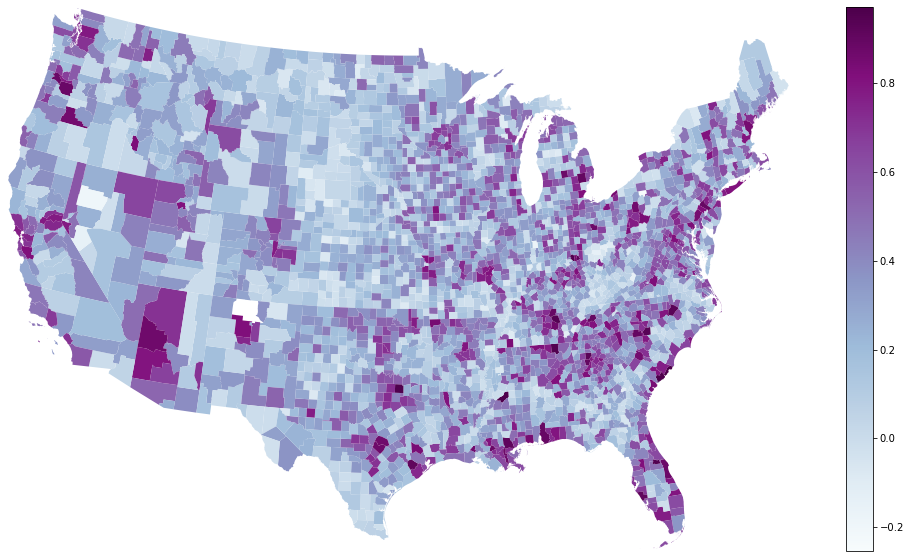

In [207]:


fig, ax = plt.subplots(figsize=(20,10))
svi_grouped.plot(ax=ax, column='RPL_Themes_maxdiff', legend=True,cmap="BuPu")
ax.set_xlim(lower48_xlim)
ax.set_ylim(lower48_ylim)
# ax.set_title("Social Vulnerability Index, Percentile Rank by State", fontname="Akkurat Pro", fontsize=15)
ax.set_axis_off()


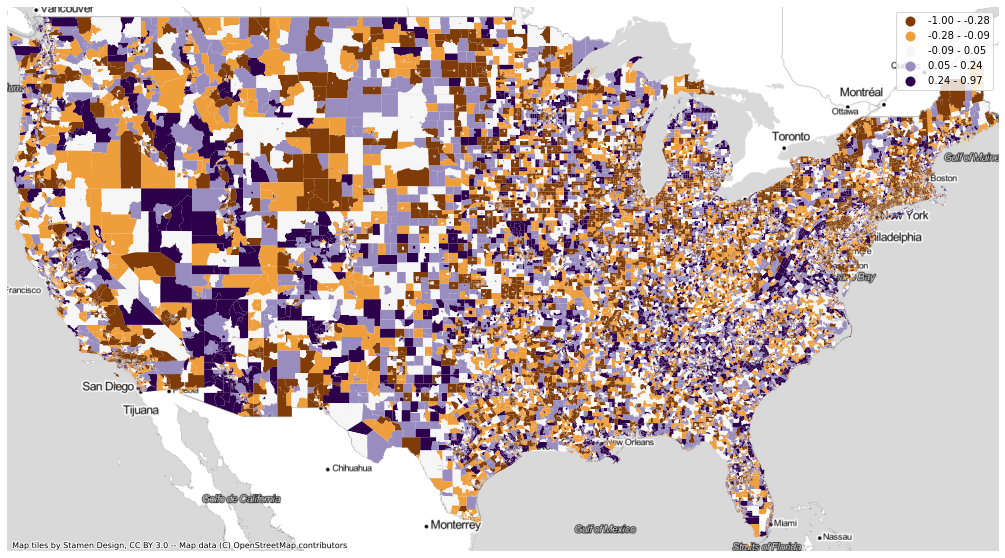

In [221]:

fig, ax = plt.subplots(figsize=(20,10))
svi_comp_merc.plot(ax=ax, column='RPL_diff', legend=True,cmap="PuOr",scheme='quantiles')
# svi_grouped.plot(ax=ax,edgecolor='grey',alpha=0.5,color='None')
ax.set_xlim(lower48_xlim)
ax.set_ylim(lower48_ylim)
ctx.add_basemap(ax, crs=svi_comp_merc.crs.to_string(),
                source=ctx.providers.Stamen.TonerLite)
# ax.set_title("Social Vulnerability Index, Percentile Rank by State", fontname="Akkurat Pro", fontsize=15)
ax.set_axis_off()


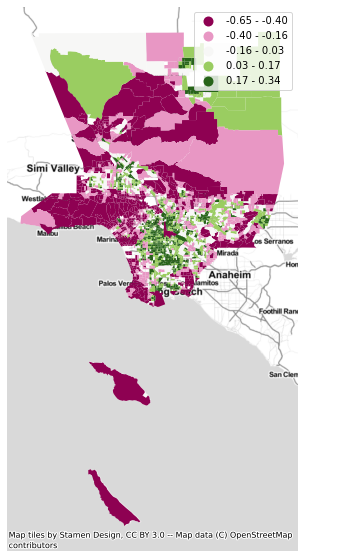

In [212]:

fig, ax = plt.subplots(figsize=(20,10))
svi_comp_merc[svi_comp_merc['STCNTY']=='06037'].plot(ax=ax, column='RPL_diff', legend=True,cmap="PiYG",scheme='quantiles')
# svi_grouped.plot(ax=ax,edgecolor='grey',alpha=0.5,color='None')
ctx.add_basemap(ax, crs=svi_comp_merc.crs.to_string(),
                source=ctx.providers.Stamen.TonerLite)
# ax.set_xlim(lower48_xlim)
# ax.set_ylim(lower48_ylim)
# ax.set_title("Social Vulnerability Index, Percentile Rank by State", fontname="Akkurat Pro", fontsize=15)
ax.set_axis_off()


#### Population Without Health Insurance USA as a whole

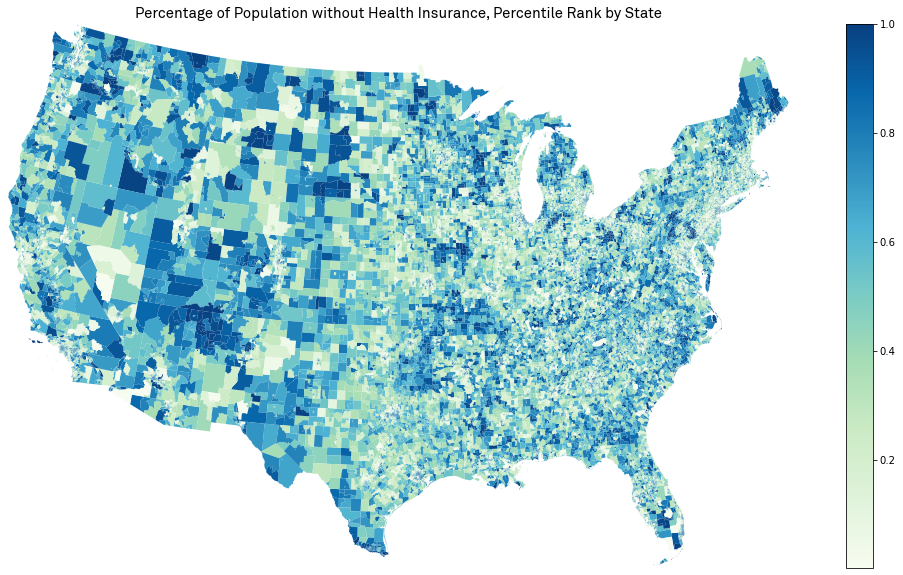

In [201]:
svi_states_albers['PER_UNINSUR'] = svi_states_albers.groupby('STATE')['EP_UNINSUR'].rank(pct=True)
fig, ax = plt.subplots(figsize=(20,10))
svi_states_albers.plot(ax=ax, column='PER_UNINSUR', legend=True,cmap="GnBu")
ax.set_xlim(lower48_xlim)
ax.set_ylim(lower48_ylim)
ax.set_title("Percentage of Population without Health Insurance, Percentile Rank by State", 
             fontname="Akkurat Pro", fontsize=15)
ax.set_axis_off()

#### Connecticut

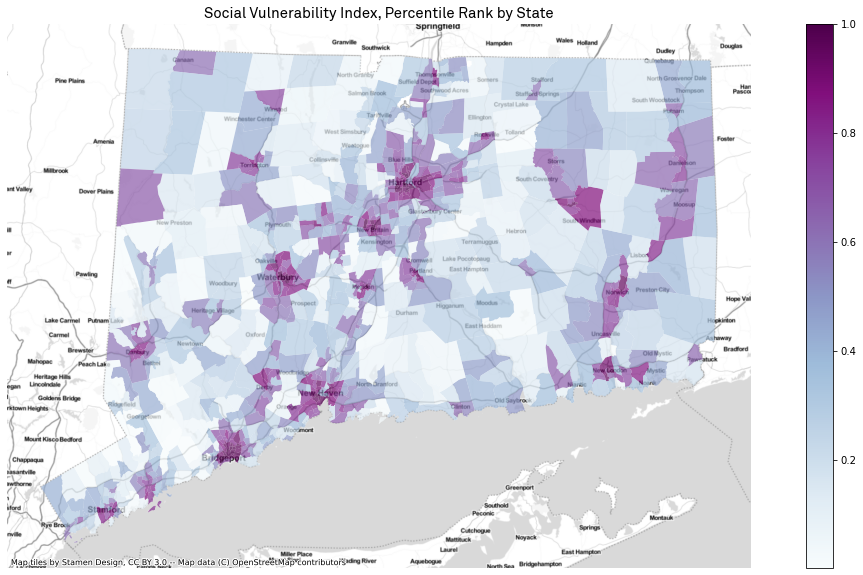

In [202]:
## creating a new haven filter 
# ct = lower_counties[lower_counties['STATEFP'] == '09']
# ct = ct.to_crs('EPSG:2234')

## subsetting just connecticut data:
ct_svi = svi_states[svi_states['ST']=='09']
ct_svi = ct_svi.to_crs('EPSG:2234')

fig, ax = plt.subplots(figsize=(20,10))
ct_svi.plot(ax=ax, column='RPL_ThemesStates',legend=True,cmap="BuPu",alpha=.7)
ctx.add_basemap(ax, crs=ct.crs.to_string(),source=ctx.providers.Stamen.TonerLite)
ax.set_title("Social Vulnerability Index, Percentile Rank by State", fontname="Akkurat Pro", fontsize=15)
ax.set_axis_off()

#### New Haven

In [203]:
# setting bounding box Hew Haven county 
nh_xlim = ([ct_svi[ct_svi['STCNTY']=='09009'].total_bounds[0],
 ct_svi[ct_svi['STCNTY']=='09009'].total_bounds[2]])
nh_ylim = ([ct_svi[ct_svi['STCNTY']=='09009'].total_bounds[1],
 ct_svi[ct_svi['STCNTY']=='09009'].total_bounds[3]])

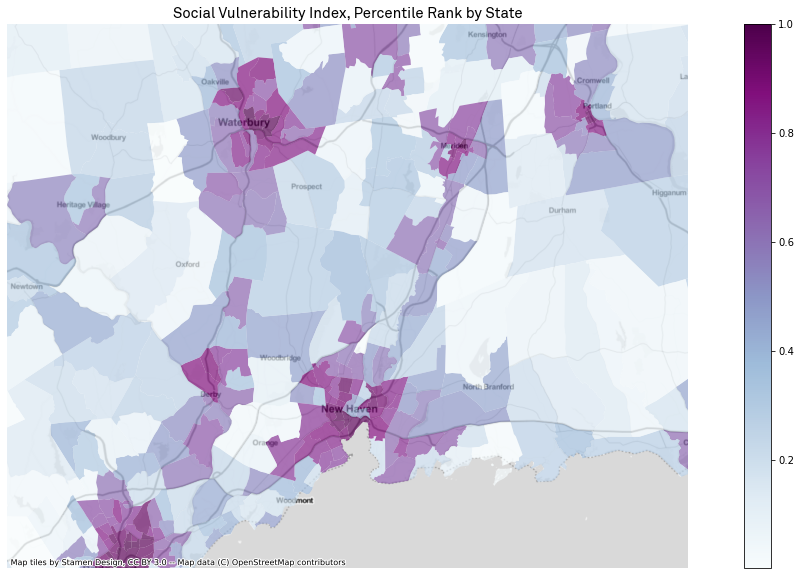

In [204]:
fig, ax = plt.subplots(figsize=(20,10))
ct_svi.plot(ax=ax, column='RPL_ThemesStates',legend=True,cmap="BuPu",alpha=.7)
# ct.plot(ax=ax,alpha=0.5)
ax.set_xlim(nh_xlim)
ax.set_ylim(nh_ylim)
ctx.add_basemap(ax, crs=ct.crs.to_string(),
                source=ctx.providers.Stamen.TonerLite)
ax.set_title("Social Vulnerability Index, Percentile Rank by State", fontname="Akkurat Pro", fontsize=15)
ax.set_axis_off()

#### New York City

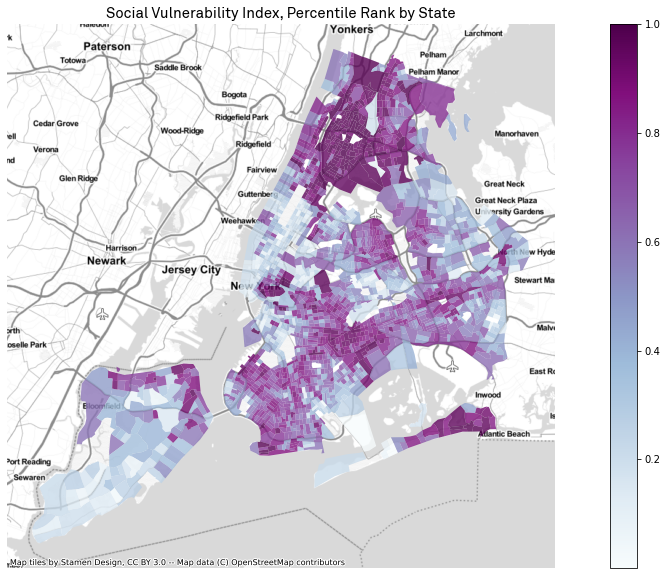

In [199]:
svi_states_webmercator = svi_states.to_crs("EPSG:3857")
fig, ax = plt.subplots(figsize=(20,10))

svi_states_webmercator[((svi_states_albers['STCNTY']=='36061')|
                   (svi_states_albers['STCNTY']=='36005')|
                   (svi_states_albers['STCNTY']=='36085')|
                   (svi_states_albers['STCNTY']=='36081')|
                  (svi_states_albers['STCNTY']=='36047'))].plot(ax=ax, 
                                                                column='RPL_ThemesStates',
                                                                legend=True,
                                                                cmap="BuPu",alpha=.8)
ctx.add_basemap(ax, crs=svi_states_webmercator.crs.to_string(),source=ctx.providers.Stamen.TonerLite)
ax.set_title("Social Vulnerability Index, Percentile Rank by State", fontname="Akkurat Pro", fontsize=15)
ax.set_axis_off()